In [1]:
#LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pylab
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import itertools
import subprocess
import pandas as pd
from scipy.interpolate import interp1d

#DATA
#data was recorded from t=0, but the experiment does not start until t=60
#there is also a 5-8s time lag between the start of the experiment and the measuring of heat in the ITC
#therefore, we disregard everything that comes before t=65
thr=65
DataCl=pd.read_excel('data/dataCl.xls')
DataCl=DataCl[DataCl.time>=thr].reset_index(drop=True)
DataS=pd.read_excel('data/dataS.xls')
DataS=DataS[DataS.time>=thr].reset_index(drop=True)
DataE=pd.read_excel('data/dataE.xls')
DataE=DataE[DataE.time>=thr].reset_index(drop=True)
DataE2=pd.read_excel('data/dataE2.xls')
DataE2=DataE2[DataE2.time>=thr].reset_index(drop=True)
DataR100=pd.read_excel('data/dataR100.xls')
DataR100=DataR100[DataR100.time>=thr].reset_index(drop=True)
DataR400=pd.read_excel('data/dataR400.xls')
DataR400=DataR400[DataR400.time>=thr].reset_index(drop=True)

# FINDING OUT THE KINETIC CONSTANTS FOR OXA48

OXA48 is a beta-lactamase that shows biphasic kinetics in the presence of chloride, like these:

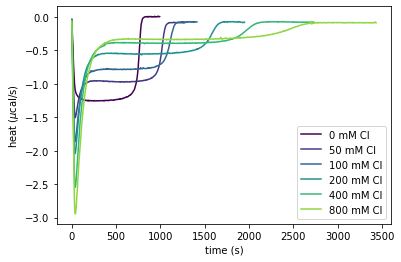

In [2]:
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    ax.plot(D,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal/s)');
ax.legend();

In [3]:
#ODE RELATING REAL AND MEASURED SIGNAL
def itc(t,y,tITC,f):
    H=float(f(t))
    return 1.0/tITC*(H-y)

#FROM REAL TO MEASURED SIGNAL
def measuredH(T,H):
    tITC=8
    f=interp1d(T,H)
    sol=solve_ivp(itc,(0,T[-1]),y0=[0],method='Radau',t_eval=T,args=(tITC,f))
    return sol.y[0,:]

#FROM MESURED TO REAL SIGNAL
def realH(D,tITC=8):
    D=pd.Series(D)
    Ddiff=D.diff()
    return D+tITC*Ddiff

def oxa(t, y, Params):      
    #Variables
    E=y[0]#dimer
    S=y[1]#antibiotic
    C=y[2]#active complex
    C2=y[3]#inactive complex
    #Parameters
    Cl=Params.Cl
    E0=Params.E0
    k0=Params.k0
    k1=Params.k1
    k2=Params.k2
    k3=Params.k3*np.heaviside(t-Params.delay,0)
    k4=Params.k4
    k5=Params.k5
    #Equations
    dEdt=E0/k0*(1-np.heaviside(t-k0,1))-k1*E*S+k2*C+k5*C2
    dSdt=-k1*E*S
    dCdt=k1*E*S-k2*C-k3*C+k4*C2
    dC2dt=k3*C-k4*C2-k5*C2
    return [dEdt, dSdt, dCdt, dC2dt]

def heat(c,k2,C,k5,C2):
    return -c*k2*C-c*k5*C2

class Parameters:
    def __init__(self,p0,p1,p2,p3,p4,p5,Cl,E0,delay):
        self.k0=p0
        self.k1=p1
        self.k2=p2
        self.k3=p3
        self.k4=p4
        self.k5=p5
        self.Cl=Cl
        self.E0=E0
        self.delay=delay
        
#OBTAIN c FROM DATA
def getc(D,S0):
    return -D.sum()/S0

#OBTAIN k2 FROM DATA
def getk2(D,c,E0):
    return (-D).max()/c/E0

#OBTAIN k3 FROM DATA
def getk3(D,Cl):
    if Cl==0:
        return 0
    xinit=35
    xend=55
    xp=range(xinit,xend)
    D1=-D[xinit:xend]
    f = lambda x, *p: p[1] * x + p[0]
    popt, pcov = curve_fit(f,xp,np.log(D1),[1,1])
    return -popt[1]

#OBTAIN k4 FROM DATA
def getk4(D,k3,Cl):
    if Cl==0:
        return 1e8
    Hs=-D[400:600].mean()
    if Cl>200:
        Hs=-D[600:1200].mean()
    Hmax=(-D).max()
    k4=k3*Hs/(Hmax-Hs)
    return k4


# DIFFERENT CL CONCENTRATIONS

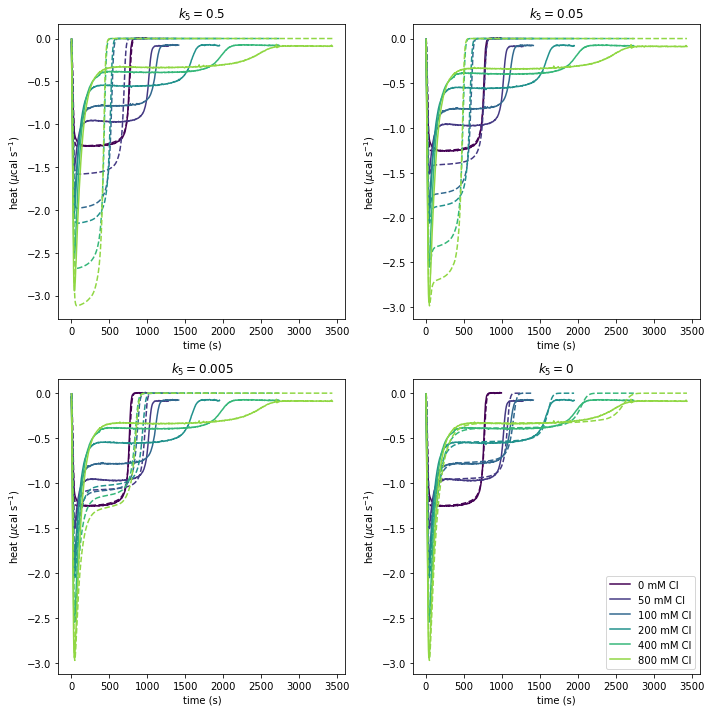

In [7]:
#SIMULATE CL DATA
E0=100e-3
S0=200
CL=[0,50,100,200,400,800]

k0=30
k1=1.05
k3=0.01
delay=37
cmap=matplotlib.cm.get_cmap('viridis')
fig=plt.figure(figsize=(10,10))
K5=[0.5,0.05,0.005,0]
for j,k5 in enumerate(K5):
    ax=fig.add_subplot(2,2,j+1)
    for i,Cl in enumerate(CL):
        D=DataCl[Cl].dropna()
        rD=realH(D)
        c=getc(rD,S0)
        k2=getk2(rD,c,E0)
        k3=0.009
        k4=getk4(rD,k3,Cl)
        if Cl==0:
            k3=0
            k4=0
        ParamV=[k0,k1,k2,k3,k4,k5]
        Params=Parameters(*ParamV,Cl,E0,delay)
        tf=len(D)
        y0=[0,S0,0,0]
        sol=solve_ivp(oxa,(0,tf),y0,method='RK45',t_eval=range(tf),max_step=0.1,args=((Params,)))
        T=sol.t
        E=sol.y[0,:]
        S=sol.y[1,:]
        C=sol.y[2,:]
        C2=sol.y[3,:]
        H=heat(c,Params.k2,C,Params.k5,C2)
        Hs=measuredH(T,H)
        ax.plot(T,Hs,ls='dashed',color=cmap(i/len(CL)))
        ax.plot(D,color=cmap(i/len(CL)), label=str(CL[i])+' mM Cl')   
    ax.set_title('$k_5=$'+str(k5))
    ax.set_xlabel('time (s)');
    ax.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax.legend()
fig.tight_layout()
fig.savefig('figures/suppfig_inactive_hydrolisis.pdf', bbox_inches='tight')